In [40]:
from PIL import Image
import torch
import numpy as np
from modeling.BaseModel import BaseModel
from modeling import build_model
from utilities.distributed import init_distributed
from utilities.arguments import load_opt_from_config_files
from utilities.constants import BIOMED_CLASSES

from inference_utils.inference import interactive_infer_image
from inference_utils.output_processing import check_mask_stats

In [ ]:
import huggingface_hub

HF_TOKEN = 'YOUR_HUGGINGFACE_TOKEN'

huggingface_hub.login(HF_TOKEN)

Token will not been saved to git credential helper. Pass `add_to_git_credential=True` if you want to set the git credential as well.
Token is valid (permission: fineGrained).
Your token has been saved to /home/theodorezhao/.cache/huggingface/token
Login successful


### Model Setup

In [42]:
# Build model config
opt = load_opt_from_config_files(["configs/biomedparse_inference.yaml"])
opt = init_distributed(opt)

# Load model from pretrained weights
pretrained_pth = 'hf_hub:microsoft/BiomedParse'

model = BaseModel(opt, build_model(opt)).from_pretrained(pretrained_pth).eval().cuda()
with torch.no_grad():
    model.model.sem_seg_head.predictor.lang_encoder.get_text_embeddings(BIOMED_CLASSES + ["background"], is_eval=True)

/home/theodorezhao/miniconda3/envs/biomedparse/lib/python3.9/site-packages/transformers/modeling_utils.py:484: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.loa

### Utility Functions

In [43]:
def plot_segmentation_masks(original_image, segmentation_masks, texts):
    ''' Plot a list of segmentation mask over an image.
    '''
    original_image = original_image[:, :, :3]
    fig, ax = plt.subplots(1, len(segmentation_masks) + 1, figsize=(10, 5))
    ax[0].imshow(original_image, cmap='gray')
    ax[0].set_title('Original Image')
    # grid off
    for a in ax:
        a.axis('off')

    for i, mask in enumerate(segmentation_masks):
        
        ax[i+1].set_title(texts[i])
        mask_temp = original_image.copy()
        mask_temp[mask > 0.5] = [255, 0, 0]
        mask_temp[mask <= 0.5] = [0, 0, 0, ]
        ax[i+1].imshow(mask_temp, alpha=0.9)
        ax[i+1].imshow(original_image, cmap='gray', alpha=0.5)
        
    
    plt.show()

In [44]:
!pip install pydicom nibabel SimpleITK

import json
import matplotlib.pyplot as plt

from inference_utils.processing_utils import read_rgb


def inference_rgb(file_path, text_prompts):
    image = read_rgb(file_path)
    
    pred_mask = interactive_infer_image(model, Image.fromarray(image), text_prompts)

    # Plot feature over image
    plot_segmentation_masks(image, pred_mask, text_prompts)
    
    return image, pred_mask


### Pathology Example

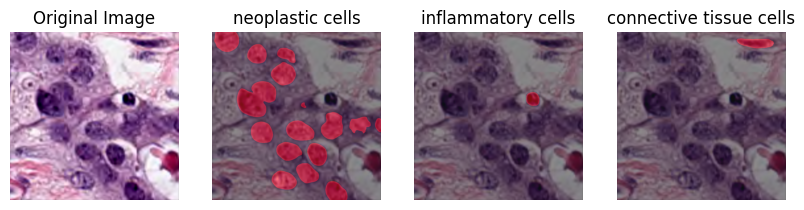

neoplastic cells P-value: 0.9318889810417548
inflammatory cells P-value: 0.4524186388107877
connective tissue cells P-value: 0.5877878893548567


In [45]:
image_path = 'examples/CT_lung_nodule.dcm'
text_prompt = ['nodule']

image_path = 'examples/Part_1_516_pathology_breast.png'
text_prompt = ['neoplastic cells', 'inflammatory cells', 'connective tissue cells']

image, pred_mask = inference_rgb(image_path, text_prompt)

for i in range(len(pred_mask)):
    adj_pvalue = check_mask_stats(image, pred_mask[i]*255, 'Pathology', text_prompt[i])
    print(f'{text_prompt[i]} P-value: {adj_pvalue}')

#### Get Cell Instances

In [46]:
from inference_utils.processing_utils import get_instances

def plot_instance_segmentation_masks(original_image, segmentation_masks, text_prompt=None):
    ''' Plot a list of segmentation mask over an image.
    '''
    original_image = original_image[:, :, :3]
    fig, ax = plt.subplots(1, len(segmentation_masks) + 1, figsize=(10, 5))
    ax[0].imshow(original_image, cmap='gray')
    ax[0].set_title('Original Image')
    # grid off
    for a in ax:
        a.axis('off')
        
    instance_masks = [get_instances(1*(mask>0.5)) for mask in segmentation_masks]
    
    mask_names = [f'Mask {i+1}' for i in range(len(segmentation_masks))]
    if text_prompt:
        mask_names = text_prompt
        for i in range(len(mask_names)):
            mask_names[i] = mask_names[i].strip()


    for i, mask in enumerate(instance_masks):
        ins_ids = np.unique(mask)
        count = len(ins_ids[ins_ids > 0])
        
        ax[i+1].set_title(f'{mask_names[i]} ({count})')
        mask_temp = np.zeros_like(original_image)
        for ins_id in ins_ids:
            if ins_id == 0:
                continue
            mask_temp[mask == ins_id] = np.random.randint(0, 255, 3)
            if ins_id == 1:
                mask_temp[mask == ins_id] = [255, 0, 0]
        
        ax[i+1].imshow(mask_temp, alpha=1)
        ax[i+1].imshow(original_image, cmap='gray', alpha=0.5)
        
        
    plt.show()

MaskImageFilter (0x7ffc6aeec600): Support for pixel type 32-bit unsigned integer for the MaskImage input has been deprecated and will be removed in future versions. Implicitly casting input to support 'sitkUInt8' type. MaskImageFilter (0x7ffc6aeec600): Support for pixel type 32-bit unsigned integer for the MaskImage input has been deprecated and will be removed in future versions. Implicitly casting input to support 'sitkUInt8' type. MaskImageFilter (0x7ffc6aeec600): Support for pixel type 32-bit unsigned integer for the MaskImage input has been deprecated and will be removed in future versions. Implicitly casting input to support 'sitkUInt8' type. 

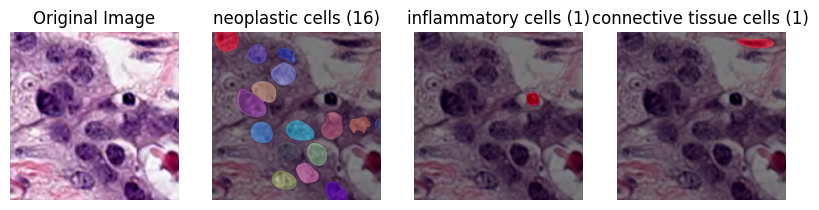

In [47]:
plot_instance_segmentation_masks(image, pred_mask, text_prompt)

### X-Ray Example

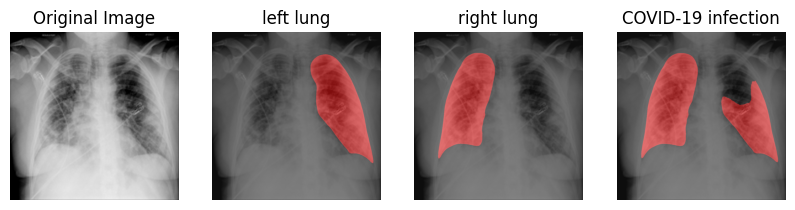

left lung P-value: 0.8696435978940136
right lung P-value: 0.256236879147936


In [48]:
image_path = 'examples/covid_1585.png'
text_prompt = ['left lung', 'right lung', 'COVID-19 infection']

image, pred_mask = inference_rgb(image_path, text_prompt)

for i in range(len(pred_mask)-1):
    adj_pvalue = check_mask_stats(image, pred_mask[i]*255, 'X-Ray-Chest', text_prompt[i])
    print(f'{text_prompt[i]} P-value: {adj_pvalue}')

### Fundus Example

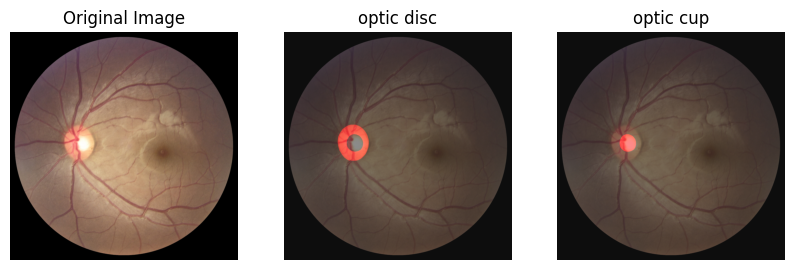

optic disc P-value: 0.6611006866483329
optic cup P-value: 0.5949915589780644


In [49]:
image_path = 'examples/T0011.jpg'
text_prompt = ['optic disc', 'optic cup']

image, pred_mask = inference_rgb(image_path, text_prompt)

for i in range(len(pred_mask)):
    adj_pvalue = check_mask_stats(image, pred_mask[i]*255, 'Fundus', text_prompt[i])
    print(f'{text_prompt[i]} P-value: {adj_pvalue}')

### Endoscope Example

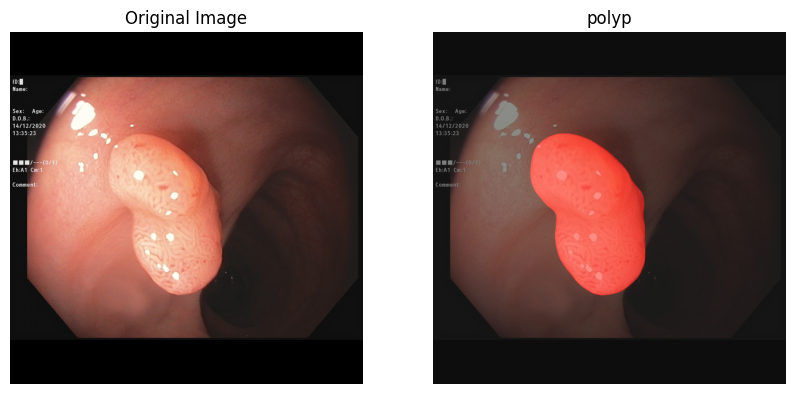

polyp P-value: 0.3015242844473123


In [50]:
image_path = 'examples/C3_EndoCV2021_00462.jpg'
text_prompt = ['polyp']

image, pred_mask = inference_rgb(image_path, text_prompt)

for i in range(len(pred_mask)):
    adj_pvalue = check_mask_stats(image, pred_mask[i]*255, 'Endoscopy', text_prompt[i])
    print(f'{text_prompt[i]} P-value: {adj_pvalue}')

### Dermoscopy Example

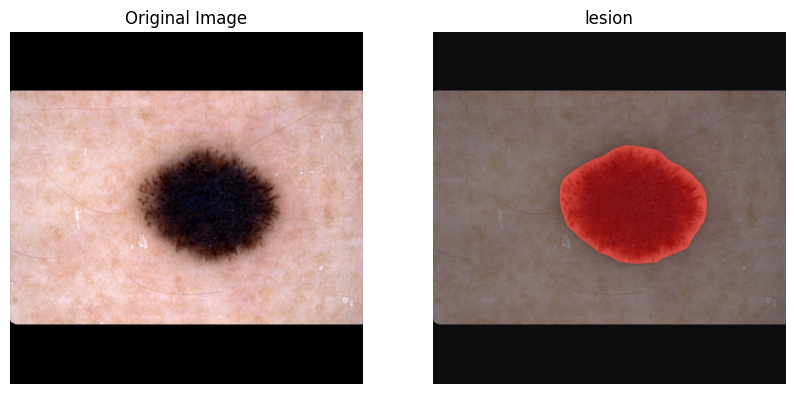

lesion P-value: 0.1477338495422816


In [51]:
image_path = 'examples/ISIC_0015551.jpg'
text_prompt = ['lesion']

image, pred_mask = inference_rgb(image_path, text_prompt)

for i in range(len(pred_mask)):
    adj_pvalue = check_mask_stats(image, pred_mask[i]*255, 'Dermoscopy', text_prompt[i])
    print(f'{text_prompt[i]} P-value: {adj_pvalue}')

### OCT Example

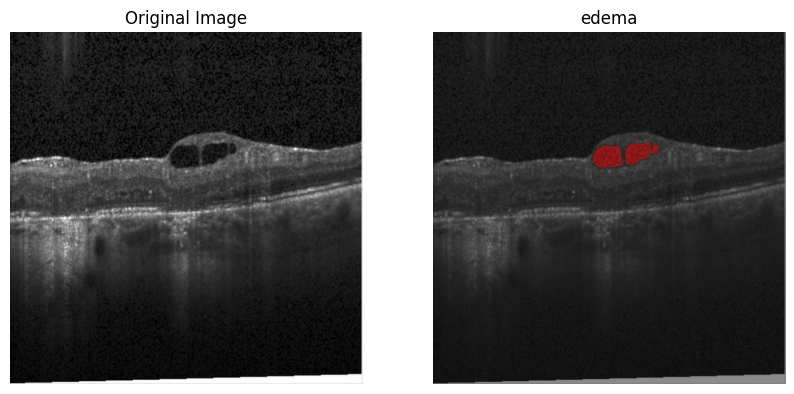

edema P-value: 0.35128171525962726


In [52]:
image_path = 'examples/144DME_as_F.jpeg'
text_prompt = ['edema']

image, pred_mask = inference_rgb(image_path, text_prompt)

for i in range(len(pred_mask)):
    adj_pvalue = check_mask_stats(image, pred_mask[i]*255, 'OCT', text_prompt[i])
    print(f'{text_prompt[i]} P-value: {adj_pvalue}')